In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import datetime

from torch.utils.tensorboard import SummaryWriter


In [2]:
log_dir = "portfolio_runs/avg_price_info/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.linear_relu_stack_val = nn.Sequential(
            nn.Linear(inputs, 500),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, 1),
        )

        self.linear_relu_stack_adv = nn.Sequential(
            nn.Linear(inputs, 500),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, outputs),
        )

    def forward(self, x):
        x.to(device)

        val = self.linear_relu_stack_val(x)
        adv = self.linear_relu_stack_adv(x)

        return val + adv - adv.mean()

class DQN_mid(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 2000),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, outputs),
        )

    def forward(self, x):
        x.to(device)

        x = self.linear_relu_stack(x)
        return x
        #return self.head(x.view(x.size(0), -1))

class DQN_big(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 2000),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 2000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(200, outputs),
        )

    def forward(self, x):
        x.to(device)

        x = self.linear_relu_stack(x)
        return x
        #return self.head(x.view(x.size(0), -1))

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loss_timeline = []

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 100000

time_intervall = 1000
n_actions = 3

policy_net = DQN(5, n_actions).to(device)
target_net = DQN(5, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if steps_done % 100 == 0:
                writer.add_scalar('eps_threshold', eps_threshold, steps_done)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #output = torch.argmax(policy_net(state))
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state, dim=0)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [6]:
RISIKOFREIER_ANLAGEZINS = 1.00
AKTIEN = 0
random.seed(a=1337)

REWARD_SMOOTHING = 0.999
ACTION_SMOOTHING = 0.9999

avg_action_0 = 0.33
avg_action_1 = 0.33
avg_action_2 = 0.33

steps_done_amount = 1000
forward_looking_timeframe = 10000

reward_array = 0

episode:  0


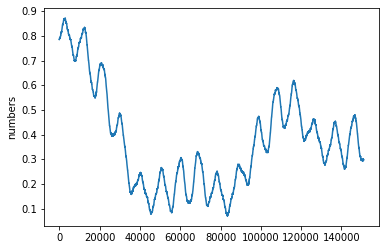

episode:  1


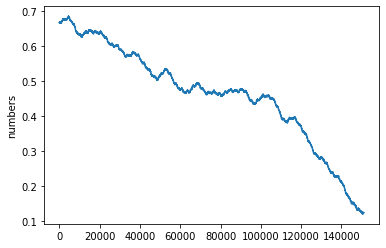

episode:  2


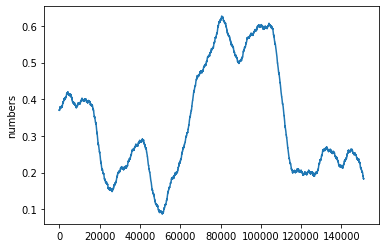

episode:  3


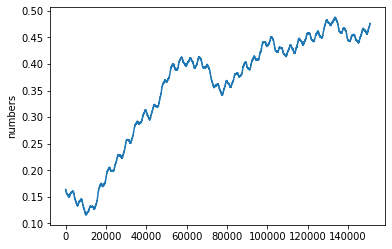

episode:  4


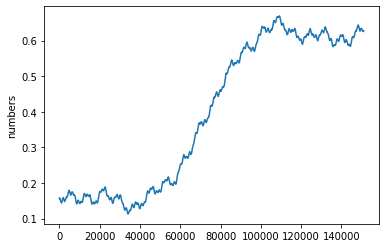

episode:  5


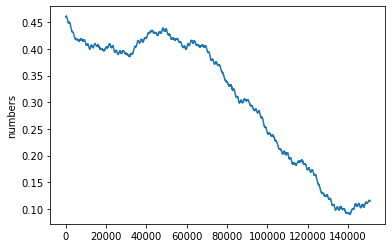

episode:  6


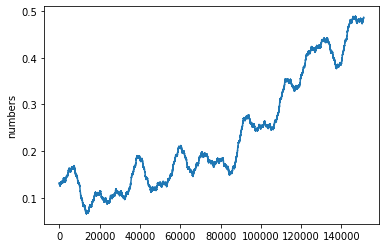

episode:  7


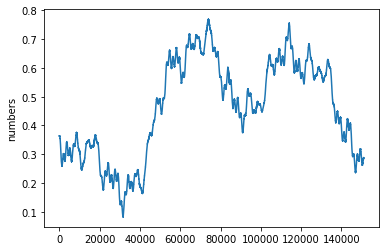

episode:  8


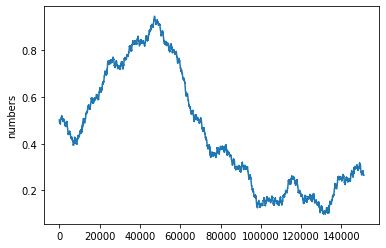

episode:  9


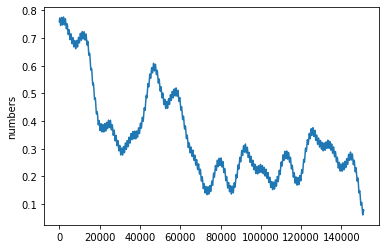

Complete


In [7]:
num_episodes = 10
num_test = 1
dataset_size = time_intervall + 150000
time_step_size = 10

for i_episode in range(num_episodes):
    MONEY_HISTORY = [100,100,100,100,100]
    testing_step = 0

    data = []

    aktien_parameter = []

    print('episode: ', i_episode)

    for i in range(1,100):
        aktien_parameter.append([random.uniform(i**4,(i+1)**4),random.gauss(0,(i**2))])

    def aktien_funktion(t):
        summe = 0
        for j in range(len(aktien_parameter)):
            summe = summe + math.sin(t/aktien_parameter[j][0]) * aktien_parameter[j][1]
        return summe

    for i in range(0,dataset_size):
        data.append(aktien_funktion(i))

    mean_data = sum(data) / len(data)

    min_data = min(data)

    for i in range(len(data)):
        data[i] = data[i] - min_data

    max_data = max(data)
    LOWER_BOUND = random.uniform(50,150)
    UPPER_BOUND = random.uniform(200,900)
    
    for i in range(len(data)):
        data[i] = ((data[i] * (UPPER_BOUND / max_data)) + LOWER_BOUND) / (900 + 150) 

    plt.plot(data)
    plt.ylabel('numbers')
    plt.show()

    for t in range(num_test):
        
        MONEY = 1.0
        AKTIEN = 0

        starting_point = time_intervall

        done = False

        time_step = 0

        while time_step < (dataset_size - time_intervall - time_step_size):

            PREIS = data[starting_point + time_step]
            PREIS_ALT = data[starting_point + time_step - 1]
            MONEY_ALT = MONEY
            AKTIEN_ALT = AKTIEN * PREIS_ALT

            added_data = [MONEY, AKTIEN]

            avg_price = sum(data[starting_point + time_step - time_intervall : starting_point + time_step]) / time_intervall
            avg_price_half = sum(data[starting_point + time_step - math.ceil(time_intervall / 2) : starting_point + time_step]) / math.ceil(time_intervall / 2)
            avg_price_quarter = sum(data[starting_point + time_step - math.ceil(time_intervall / 4) : starting_point + time_step]) / math.ceil(time_intervall / 4)

            #print(len(data[starting_point + time_step - (time_intervall - len(added_data)) : starting_point + time_step] + added_data))

            state = torch.tensor([[avg_price, avg_price_half, avg_price_quarter] + added_data], device=device)
            #torch.cat((state,added_data),0)
            # Select and perform an action
            action = select_action(state)

            #expected_return = 10 * PREIS - (sum(data[starting_point + time_step : starting_point + time_step + forward_looking_timeframe]) / forward_looking_timeframe)
            jump = False
            if action.item() == 0:
                #kaufen
                avg_action_0 = avg_action_0 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 1
                avg_action_1 = avg_action_1 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                avg_action_2 = avg_action_2 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                jump = True
                AKTIEN += (MONEY * 0.2) / PREIS
                MONEY -= MONEY * 0.2
            elif action.item() == 1:
                #verkaufen
                avg_action_0 = avg_action_0 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                avg_action_1 = avg_action_1 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 1
                avg_action_2 = avg_action_2 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                jump = True
                MONEY += AKTIEN * PREIS
                AKTIEN = 0
            elif action.item() == 2:
                avg_action_0 = avg_action_0 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                avg_action_1 = avg_action_1 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 0
                avg_action_2 = avg_action_2 * ACTION_SMOOTHING + (1 - ACTION_SMOOTHING) * 1
                #MONEY *= 0.999

            if time_step >= dataset_size - time_intervall:
                MONEY += AKTIEN * PREIS
                AKTIEN = 0
                break

            reward = (MONEY + AKTIEN * PREIS) - (MONEY_ALT + AKTIEN_ALT)
            time_step += time_step_size

            testing_step = testing_step + 1

            #reward = (MONEY + AKTIEN * PREIS) / (MONEY_ALT + AKTIEN_ALT * PREIS_ALT) - 1
            #reward = float(MONEY - MONEY_ALT)
                
            #reward = int(float(reward))
            reward_array = reward_array * REWARD_SMOOTHING + (1 - REWARD_SMOOTHING) * reward

            if steps_done % steps_done_amount == 0:
                writer.add_scalar('avg reward', reward_array, steps_done)
                writer.add_scalar('MONEY', MONEY + AKTIEN * PREIS, steps_done)
                #writer.add_scalar('AKTIEN', AKTIEN * PREIS, steps_done)
                writer.add_scalar('avg action 0', avg_action_0, steps_done)
                writer.add_scalar('avg action 1', avg_action_1, steps_done)
                writer.add_scalar('avg action 2', avg_action_2, steps_done)

            reward = torch.tensor([reward], device=device)

            # Observe new state
            if not done:
                added_data = [MONEY, AKTIEN]

                avg_price = sum(data[starting_point + time_step - time_intervall : starting_point + time_step]) / time_intervall
                avg_price_half = sum(data[starting_point + time_step - math.ceil(time_intervall / 2) : starting_point + time_step]) / math.ceil(time_intervall / 2)
                avg_price_quarter = sum(data[starting_point + time_step - math.ceil(time_intervall / 4) : starting_point + time_step]) / math.ceil(time_intervall / 4)

                next_state = torch.tensor([[avg_price, avg_price_half, avg_price_quarter] + added_data], device=device)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Perform one step of the optimization (on the policy network)
            if (steps_done) % OPTIMIZE_MODEL == 0:
                optimize_model()

            # Update the target network, copying all weights and biases in DQN
            if (steps_done) % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

print('Complete')

something